In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'categories', 'feature_names', 'url', 'details', 'target', 'DESCR'])

In [3]:
X,Y = mnist['data'], mnist['target']
print('X shape : {} Y shape : {}'.format(X.shape, Y.shape))

X shape : (70000, 784) Y shape : (70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) # 원래 크기

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()
print('matched label : ', Y[0])

<Figure size 640x480 with 1 Axes>

matched label :  5


In [5]:
print('X type : {} Y type : {}'.format( type(X[0]), type(Y[0])))

Y = Y.astype(np.uint8)

X type : <class 'numpy.ndarray'> Y type : <class 'str'>


In [6]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

Y_train_5 = (Y_train == 5)
Y_test_5 = (Y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, Y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state= 42)

for train_idx, test_idx in skfolds.split(X_train, Y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    Y_train_folds = Y_train_5[train_idx]
    
    X_test_folds = X_train[test_idx]
    Y_test_folds = Y_train_5[test_idx]
    
    
    clone_clf.fit(X_train_folds, Y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == Y_test_folds)
    
    print('accuracy : {}'.format(n_correct / len(Y_test_folds)) )

accuracy : 0.95035
accuracy : 0.96035
accuracy : 0.9604


In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, Y_train_5, cv=3, scoring = "accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [22]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, Y_train_5, cv=3 , scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, Y_train_5, cv=3 )

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(Y_train_5, y_train_pred))
print(recall_score(Y_train_5, y_train_pred))
print(f1_score(Y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
thr = 8000
y_some_digit_pred = (y_scores > thr)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, Y_train_5,cv=3 , method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thr = precision_recall_curve(Y_train_5, y_scores)


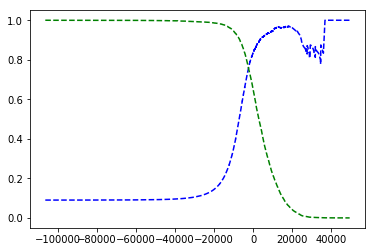

In [38]:
def plot_precision_recall_vs_thr(precision, recall, thr):
    plt.plot(thr, precision[:-1], "b--", label = "precision")
    plt.plot(thr, recall[:-1], "g--", label = "recall")
    
plot_precision_recall_vs_thr(precisions, recalls, thr)
plt.show()
    

In [40]:
thr_90_precision = thr[np.argmax(precisions >=0.90)]
print(thr_90_precision)

3370.0194991439557


In [41]:
y_train_pred_90 = (y_scores >= thr_90_precision)


In [43]:
print(precision_score(Y_train_5,y_train_pred_90))
print(recall_score(Y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(Y_train_5, y_scores)

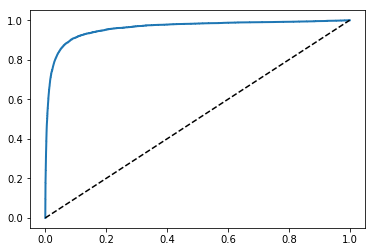

In [46]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth =2, label = label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()